In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, random_state=42)

# Define models and parameter grids
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression()),
    'SVM': make_pipeline(StandardScaler(), SVC()),
    'Naive Bayes': make_pipeline(StandardScaler(), GaussianNB()),
    'Random Forest': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'XGBoost': make_pipeline(StandardScaler(), XGBClassifier())
}

param_grids = {
    'Logistic Regression': {'logisticregression__C': [0.1, 1, 10]},
    'SVM': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf'], 'svc__gamma':['scale', 'auto']},
    'Naive Bayes': {},
    'Random Forest': {'randomforestclassifier__n_estimators': [100, 200,500], 'randomforestclassifier__max_depth': [None,3, 10]},
    'XGBoost': {'xgbclassifier__n_estimators': [100, 200], 'xgbclassifier__max_depth': [3, 5]}
}

# Nested cross-validation and model evaluation
results = []
for model_name, model in models.items():
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(model,param_grid=param_grids[model_name], cv=inner_cv, scoring='accuracy')
    scores = cross_val_score(grid_search, X, y, cv=outer_cv, scoring='accuracy')
    results.append({'Model': model_name, 'Mean Accuracy': np.mean(scores), 'Std Accuracy': np.std(scores)})

    # Train the best model on the entire dataset
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Confusion matrix and classification report
    y_pred = best_model.predict(X)
    print(f'\n{model_name}')
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))




Logistic Regression
[[412  89]
 [ 94 405]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       501
           1       0.82      0.81      0.82       499

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


SVM
[[489  12]
 [  6 493]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       501
           1       0.98      0.99      0.98       499

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Naive Bayes
[[416  85]
 [112 387]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       501
           1       0.82      0.78      0.80       499

    accuracy                           0.80      1000
   macro avg       0

## It is advised to retrain the model after cross-validation and hyperparameters tuning to ensure good results

In [3]:
# Tabulate results
results_df = pd.DataFrame(results).sort_values('Mean Accuracy', ascending=False)
print('\nModel Performance:')
print(results_df)


Model Performance:
                 Model  Mean Accuracy  Std Accuracy
1                  SVM          0.941      0.020591
4              XGBoost          0.906      0.012806
3        Random Forest          0.904      0.017720
0  Logistic Regression          0.804      0.032465
2          Naive Bayes          0.790      0.032249


# Calibration of Logisitic Regression Model

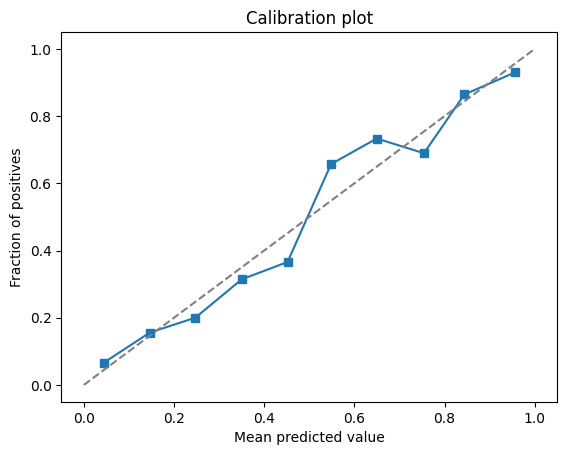

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV , calibration_curve
import matplotlib.pyplot as plt

log_reg = models['Logistic Regression']
X , y = make_classification(n_samples=2000, n_features=20, n_informative=15, random_state=42)
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg.fit(X_train, y_train)

# Predict probabilities
prob_pos = log_reg.predict_proba(X_test)[:, 1] # prob_pos previously

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives,  's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.ylim([-0.05, 1.05])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.show()

as we can see the model is almost calibrated

## How Palatte Scale works ?

In [40]:
# 1- Create a new dataset with logits as features
X_logits = log_reg.predict_log_proba(X_test)[:, 1]

# 2-  Train a calibration model on the logits
calibration_model = LogisticRegression()
calibration_model.fit(X_logits.reshape(-1,1), y_test)

# testing the log_reg with the calibration model with new instance
X,y = make_classification(n_samples=500, n_features=20, n_informative=15, random_state=20)

# get the logit from base_model
instance_logit = log_reg.predict_log_proba(X)

# predict with the calibrated
instance_logit = instance_logit[:,1].reshape(-1,1)

calibrated_pred = calibration_model.predict(instance_logit)

calibrated_pred_proba = calibration_model.predict_proba(instance_logit)[:,1]
prob_pos = log_reg.predict_proba(X)[:, 1] # prob_pos previously



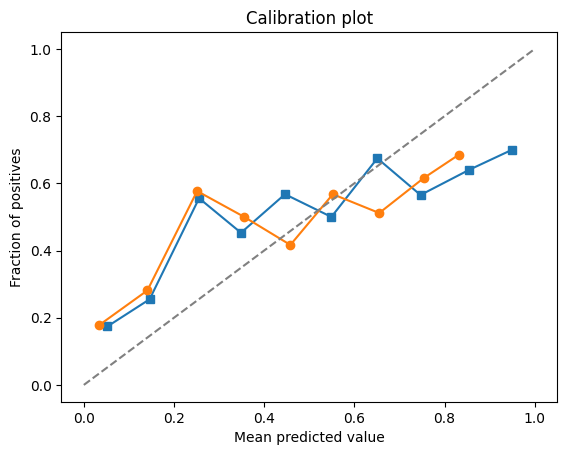

In [42]:
fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=10)
fraction_of_positives2, mean_predicted_value2 = calibration_curve(y, calibrated_pred_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,  's-')
plt.plot(mean_predicted_value2, fraction_of_positives2,  'o-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.ylim([-0.05, 1.05])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.show()